<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_nn_vs_interdofs_paper(models, schemes, h_true_list, K_true, C_true, k_nl_true, device="cpu"):

    # -------------------------
    # 1. Concatenate true data
    # -------------------------
    h_true = torch.cat(h_true_list, dim=0).to(device)   # (N, 8)
    x = h_true[:, :4]
    v = h_true[:, 4:]

    # Inter-DOF displacement
    dx1 = x[:, 0]
    dx2 = x[:, 1] - x[:, 0]
    dx3 = x[:, 2] - x[:, 1]
    dx4 = x[:, 3] - x[:, 2]
    dx_list = [dx4, dx3, dx2, dx1]

    row_labels = [
        r"$x_4 - x_3$",
        r"$x_3 - x_2$",
        r"$x_2 - x_1$",
        r"$x_1$",
    ]
    # Which dv component to plot in each row (4→3→2→1, as in the original code)
    row_dof_idx = [3, 2, 1, 0]

    scheme_titles = {
        1: "Scheme 1 (no physics)",
        2: "Scheme 2 (weak physics)",
        3: "Scheme 3 (strong physics)"
    }
    colors = {1: "tab:red", 2: "tab:blue", 3: "tab:green"}

    n_rows = 4
    n_cols = len(schemes)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 3 * n_rows),
                             squeeze=False)

    # Precompute numpy versions of x-axis (same for all schemes)
    dx_np = [d.cpu().numpy() for d in dx_list]

    # -------------------------
    # 2. Loop over schemes
    # -------------------------
    for c, s in enumerate(schemes):
        model = models[s].to(device)
        model.eval()

        # NN(h_true):
        with torch.no_grad():
            nn_out = model.mlp(h_true).cpu().numpy()   # (N, 4)

        # Analytic discrepancy for this scheme
        a_disc = discrepancy_reference(
            x, v,
            scheme=s,
            K=K_true.to(device),
            C=C_true.to(device),
            k_nl=k_nl_true
        )
        a_disc_np = a_disc.cpu().numpy()

        # -------------------------
        # 3. Loop over rows / DOFs
        # -------------------------
        for r in range(n_rows):
            dof_idx = row_dof_idx[r]
            ax = axes[r, c]

            xs = dx_np[r]                  # inter-DOF displacement
            nn_vals = nn_out[:, dof_idx]   # NN component (dv_i)
            ref_vals = a_disc_np[:, dof_idx]  # reference discrepancy

            # Sort by x-axis for smooth curves
            idx = np.argsort(xs)
            xs_sorted = xs[idx]
            nn_sorted = nn_vals[idx]
            ref_sorted = ref_vals[idx]

            # Reference (solid black)
            ax.plot(xs_sorted, ref_sorted,
                    color="black", linewidth=2, label="reference")

            # NN(h_true) (dotted)
            ax.plot(xs_sorted, nn_sorted,
                    linestyle=":", linewidth=2,
                    color=colors.get(s, "gray"),
                    label=f"scheme {s}")

            ax.set_ylim(-40, 60)
            ax.set_xlabel(row_labels[r])
            ax.set_ylabel(f"component {dof_idx+1}")
            ax.grid(True)

            if r == 0:
                ax.set_title(scheme_titles.get(s, f"Scheme {s}"))
                ax.legend()

    plt.tight_layout()
    plt.show()


In [89]:
pip install pysindy

In [90]:
pip install torchdiffeq

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. PROBLEM SETUP

# Parameters
k1 = k2 = k3 = k4 = 10.0
c1 = c2 = c3 = c4 = 0.5
m1 = m2 = m3 = m4 = 1.0
k_nl_true = 2.0

# Mass matrix (all ones -> identity)
M = torch.eye(4, device=device)

# Stiffness matrix K for a 4-DOF shear building (fixed base)
K = torch.tensor([
    [k1 + k2,   -k2,       0.0,      0.0],
    [-k2,       k2 + k3,  -k3,       0.0],
    [0.0,      -k3,       k3 + k4,  -k4],
    [0.0,       0.0,      -k4,       k4]
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c4)
C = torch.diag(torch.tensor([c1, c2, c3, c4], dtype=torch.float32, device=device))

# Initial conditions (8D state: [x1,x2,x3,x4,v1,v2,v3,v4])
h0_1 = torch.tensor([ 2.0,  0.0, 0.0, 0.0,  0.0, -2.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_2 = torch.tensor([-2.0,  0.0, 0.0, 3.0, -2.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_3 = torch.tensor([ 0.0,  4.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)

# Time grids
dt = 0.01
t_train_end = 6.0
t_test_end = 12.0

# Same dt for train/test
t_train = torch.linspace(0.0, t_train_end, int(t_train_end / dt) + 1, device=device)
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)


In [92]:
# =====================================
# 2. Ground-truth (nonlinear) dynamics
# =====================================

def ground_truth_rhs(t, h):

    x = h[:4]
    v = h[4:]

    # Linear restoring + damping: -Kx - Cv
    lin_force = -K @ x - C @ v

    # Cubic nonlinearity on DOF 1 only
    f_nl = torch.zeros_like(x)
    f_nl[0] = -k_nl_true * x[0]**3

    # Total acceleration (M = I)
    a = lin_force + f_nl

    dh = torch.zeros_like(h)
    dh[:4] = v      # x' = v
    dh[4:] = a      # v' = a
    return dh

In [93]:
# ==============================================
# 3. PINODE schemes (physics + neural discrepancy)
# ==============================================

class PINODEFuncScheme1(nn.Module):
    def __init__(self, K, C):
        super().__init__()

        # Purely data-driven dv: NN learns full acceleration
        self.mlp = nn.Sequential(
            nn.Linear(8, 30),  # input = [x(4), v(4)]
            nn.Tanh(),
            nn.Linear(30, 4)   # output = dv(4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        # dv_phys = 0 in scheme 1 -> no K, C used here
        dv_corr = self.mlp(h)

        dh = torch.zeros_like(h)
        dh[..., :4] = v          # physics: x' = v
        dh[..., 4:] = dv_corr    # v' = NN(h)
        return dh



class PINODEFuncScheme2(nn.Module):
    def __init__(self, K, C):
        super().__init__()

        # Incorrect physics: only 70% of the true K, C
        self.K = nn.Parameter(0.7 * K.clone(), requires_grad=False)
        self.C = nn.Parameter(0.7 * C.clone(), requires_grad=False)

        # NN takes full state and outputs dv correction
        self.mlp = nn.Sequential(
            nn.Linear(8, 30),
            nn.Tanh(),
            nn.Linear(30, 4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        # dv_phys = -0.7 Kx - 0.7 Cv
        dv_phys = (
            - self.K @ x.unsqueeze(-1)
            - self.C @ v.unsqueeze(-1)
        ).squeeze(-1)

        # NN should learn missing 0.3*(Kx+Cv) and the nonlinear term
        a_corr = self.mlp(h)

        a = dv_phys + a_corr

        dh = torch.zeros_like(h)
        dh[..., :4] = v          # x' = v
        dh[..., 4:] = a          # v' = physics + NN correction
        return dh



class PINODEFuncScheme3(nn.Module):
    def __init__(self, K, C):
        super().__init__()
        # Full, correct linear physics hard-coded
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)

        # NN learns only the nonlinear discrepancy ideally
        self.mlp = nn.Sequential(
            nn.Linear(8, 30),
            nn.Tanh(),
            nn.Linear(30, 4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        # dv_phys = -Kx - Cv (exact linear physics)
        dv_phys = (
            - self.K @ x.unsqueeze(-1)
            - self.C @ v.unsqueeze(-1)
        ).squeeze(-1)

        # NN correction on top of physics
        dv_corr = self.mlp(h)

        a = dv_phys + dv_corr

        dh = torch.zeros_like(h)
        dh[..., :4] = v          # x' = v
        dh[..., 4:] = a          # v' = physics + NN correction
        return dh


In [94]:
# ============================
# 4. Data generation
# ============================

@torch.no_grad()
def generate_trajectory(h0, t_grid):

    # This is your “perfect” reference trajectory
    sol = odeint(ground_truth_rhs, h0, t_grid, method='rk4')  # (T, 8)
    return sol


print("Generating ground truth data...")
# Training trajectories (0–6s)
traj1_train = generate_trajectory(h0_1, t_train)  # IC1
traj2_train = generate_trajectory(h0_2, t_train)  # IC2

# Test/generalization trajectories (0–12s)
traj2_test = generate_trajectory(h0_2, t_test)    # IC2
traj3_test = generate_trajectory(h0_3, t_test)    # IC3

Generating ground truth data...


In [95]:
# ============================
# 5. Training + Evaluation utilities
# ============================

import torch
import numpy as np
import matplotlib.pyplot as plt

def discrepancy_reference(x, v, scheme, K, C, k_nl):
    # x, v: (T,4)

    # Linear part in standard form: Kx + Cv
    lin = torch.matmul(x, K.T) + torch.matmul(v, C.T)

    # Nonlinear force only on DOF1: k_nl * x1^3
    f_nl = torch.zeros_like(x)
    f_nl[:, 0] = k_nl * x[:, 0]**3

    # True acceleration according to full physics: a_true = -(Kx + Cv + f_nl)
    a_true = -(lin + f_nl)

    # Depending on the scheme, discrepancy is defined differently
    if scheme == 1:
        # Scheme 1 has no physics in v', so discrepancy = full true acceleration
        a_disc = a_true
    elif scheme == 2:
        # Scheme 2 uses a_phy = -0.7(Kx + Cv)
        a_phy = -0.7 * lin
        # discrepancy = a_true - a_phy = missing 0.3*lin - f_nl
        a_disc = a_true - a_phy
    elif scheme == 3:
        # Scheme 3 uses full linear physics a_phy = -lin
        a_phy = -lin
        # discrepancy = a_true - a_phy = -f_nl (pure nonlinear)
        a_disc = a_true - a_phy
    else:
        raise ValueError("scheme must be 1, 2, or 3")

    return a_disc

def true_discrepancy_on_traj(scheme, traj):
    # traj: (T,8) [x(4), v(4)] along a TRUE trajectory
    x = traj[..., :4]
    v = traj[..., 4:]
    # This returns the analytic discrepancy a_disc(T,4) for that scheme
    return discrepancy_reference(x, v, scheme=scheme, K=K, C=C, k_nl=k_nl_true)


def train_scheme_with_disc(scheme, model, num_epochs=200, lr=1e-3, lambda_disc=1.0):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in range(1, num_epochs+1):
        opt.zero_grad()

        # Integrate PINODE for both ICs over training horizon [0,6]
        pred1 = odeint(model, h0_1, t_train, method='rk4')
        pred2 = odeint(model, h0_2, t_train, method='rk4')

        # DATA LOSS: match trajectories x,v over time
        loss_state = mse(pred1, traj1_train) + mse(pred2, traj2_train)

        # DISCREPANCY LOSS: match NN(h_true) to analytic discrepancy
        with torch.no_grad():
            # These are the ground-truth discrepancy values from physics
            disc1_true = true_discrepancy_on_traj(scheme, traj1_train)
            disc2_true = true_discrepancy_on_traj(scheme, traj2_train)

        # Evaluate NN discrepancy on true states (no ODE integration here)
        disc1_nn = model.mlp(traj1_train)
        disc2_nn = model.mlp(traj2_train)
        loss_disc = mse(disc1_nn, disc1_true) + mse(disc2_nn, disc2_true)

        # Total loss: data fit + physics-discrepancy fit
        loss = loss_state + lambda_disc * loss_disc
        loss.backward()
        opt.step()

        if epoch % 100 == 0 or epoch == 1:
             print(f"[{scheme}] Epoch {epoch:4d}, loss = {loss.item():.4e}")

    return model


def train_scheme_with_disc_2(scheme, model, num_epochs=200, lr=1e-3, lambda_disc=1.0):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    # Phase 1: train only on IC1 for 1250 epochs
    for epoch in range(1, 1251):
        opt.zero_grad()

        # Model trajectory for IC1
        pred1 = odeint(model, h0_1, t_train, method='rk4')

        # Data loss for IC1 only
        loss_state = mse(pred1, traj1_train)

        # Discrepancy supervision on TRUE traj1
        with torch.no_grad():
            disc1_true = true_discrepancy_on_traj(scheme, traj1_train)

        disc1_nn = model.mlp(traj1_train)
        loss_disc = mse(disc1_nn, disc1_true)

        loss = loss_state + lambda_disc * loss_disc
        loss.backward()
        opt.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"[{scheme}] Epoch {epoch:4d}, loss = {loss.item():.4e}")

    # Phase 2: train only on IC2 for 3750 epochs
    for epoch in range(1, 3751):
        opt.zero_grad()

        # Model trajectory for IC2
        pred2 = odeint(model, h0_2, t_train, method='rk4')

        # Data loss for IC2 only
        loss_state = mse(pred2, traj2_train)

        # Discrepancy supervision on TRUE traj2
        with torch.no_grad():
            disc2_true = true_discrepancy_on_traj(scheme, traj2_train)

        disc2_nn = model.mlp(traj2_train)
        loss_disc = mse(disc2_nn, disc2_true)

        loss = loss_state + lambda_disc * loss_disc
        loss.backward()
        opt.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"[{scheme}] Epoch {epoch:4d}, loss = {loss.item():.4e}")

    return model


@torch.no_grad()
def evaluate_scheme(scheme_name, model):

    loss_fn = nn.MSELoss()

    # IC2, 0–12s
    pred2 = odeint(model, h0_2, t_test, method='rk4')
    mse2_full = loss_fn(pred2, traj2_test).item()

    # split at 6s (same dt as train)
    mid_idx = len(t_train)
    mse2_0_6  = loss_fn(pred2[:mid_idx], traj2_test[:mid_idx]).item()
    mse2_6_12 = loss_fn(pred2[mid_idx:], traj2_test[mid_idx:]).item()

    # IC3, 0–12s
    pred3 = odeint(model, h0_3, t_test, method='rk4')
    mse3_full = loss_fn(pred3, traj3_test).item()
    mse3_0_6  = loss_fn(pred3[:mid_idx], traj3_test[:mid_idx]).item()
    mse3_6_12 = loss_fn(pred3[mid_idx:], traj3_test[mid_idx:]).item()

    print(f"\n=== Evaluation for {scheme_name} ===")
    print(f"IC2 (0–12s) MSE total: {mse2_full:.4e}")
    print(f"IC2 (0–6s)  MSE:       {mse2_0_6:.4e}")
    print(f"IC2 (6–12s) MSE:       {mse2_6_12:.4e}")
    print(f"IC3 (0–12s) MSE total: {mse3_full:.4e}")
    print(f"IC3 (0–6s)  MSE:       {mse3_0_6:.4e}")
    print(f"IC3 (6–12s) MSE:       {mse3_6_12:.4e}")


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

In [96]:
# ============================
# 6. Main: train all schemes
# ============================

if __name__ == "__main__":

    save_path = "/content/drive/MyDrive/pinode_models/"

    # Load already-trained models (you can uncomment training if needed)
    model1 = PINODEFuncScheme1(K, C)
    model1.load_state_dict(torch.load(save_path + "scheme_1_retryV4_5000.pth", map_location=device))

    model2 = PINODEFuncScheme2(K, C)
    model2.load_state_dict(torch.load(save_path + "scheme_2_retryV4_5000.pth", map_location=device))

    model3 = PINODEFuncScheme3(K, C)
    model3.load_state_dict(torch.load(save_path + "scheme_3_retryV4_5000.pth", map_location=device))

    # evaluate_scheme("Scheme 1", model1)
    # evaluate_scheme("Scheme 2", model2)
    # evaluate_scheme("Scheme 3", model3)

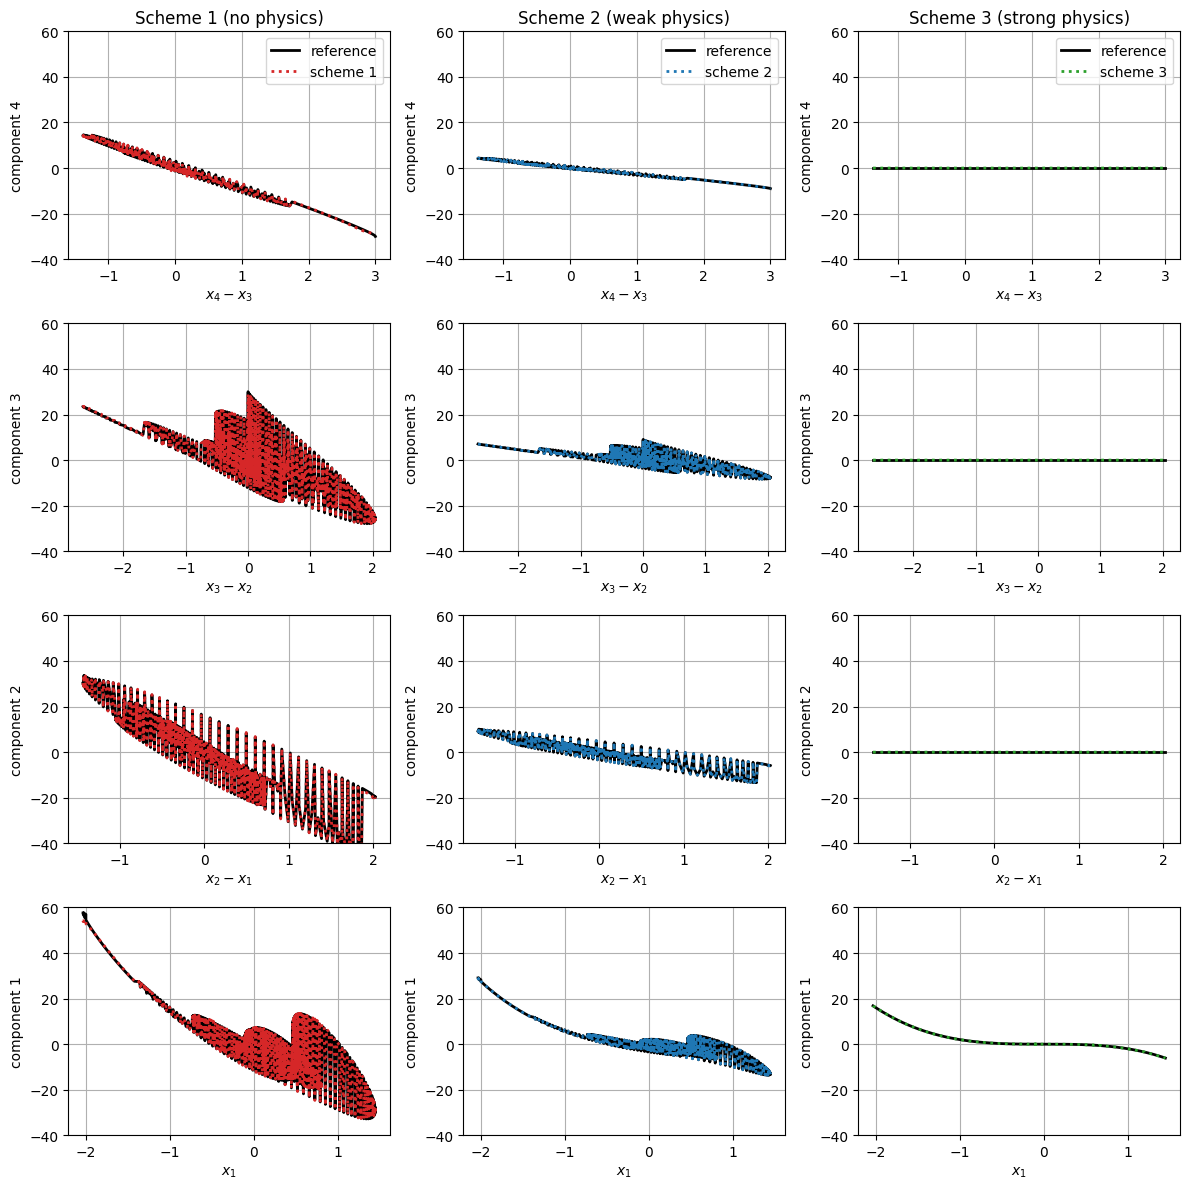

In [97]:
models = {
    1: model1,  # trained PINODEFuncScheme1
    2: model2,  # trained PINODEFuncScheme2
    3: model3,  # trained PINODEFuncScheme3
}

h_true_list = [traj2_train]

plot_nn_vs_interdofs_paper(models=models, schemes=[1, 2, 3], h_true_list=h_true_list, K_true=K, C_true=C, k_nl_true=k_nl_true, device=device)


In [98]:
def plot_ic_results(t, gt, pred1, pred2, pred3, save_path=None):

    # Labels for the 8 state components: 4 displacements + 4 velocities
    labels = [
        "x1(t)", "x2(t)", "x3(t)", "x4(t)",
        "v1(t)", "v2(t)", "v3(t)", "v4(t)"
    ]

    # Create 4x2 grid of subplots (8 total, one per state dimension)
    fig, axes = plt.subplots(4, 2, figsize=(16, 14))
    axes = axes.flatten()   # flatten into a 1D array for easy indexing

    # Loop through the 8 states (x1..x4, v1..v4)
    for i in range(8):
        ax = axes[i]

        # Plot ground-truth trajectory
        ax.plot(t.cpu(), gt[:, i].cpu(), 'k', lw=2, label="Ground Truth")

        # Plot predictions from each PINODE scheme
        ax.plot(t.cpu(), pred1[:, i].detach().cpu(), 'b--', lw=1.5, label="Scheme 1")
        ax.plot(t.cpu(), pred2[:, i].detach().cpu(), 'r--', lw=1.5, label="Scheme 2")
        ax.plot(t.cpu(), pred3[:, i].detach().cpu(), 'g--', lw=1.5, label="Scheme 3")

        # Title of each subplot = name of that state component
        ax.set_title(labels[i])

        # x-axis label is time for all plots
        ax.set_xlabel("Time (s)")

        # Optional grid for readability
        ax.grid(True)

        # Only show legend on the first subplot to avoid repetition
        if i == 0:
            ax.legend(loc="upper right")

    # Remove overlaps / improve spacing
    plt.tight_layout()

    # Save figure to file if a path was given
    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    # Display the plots
    plt.show()


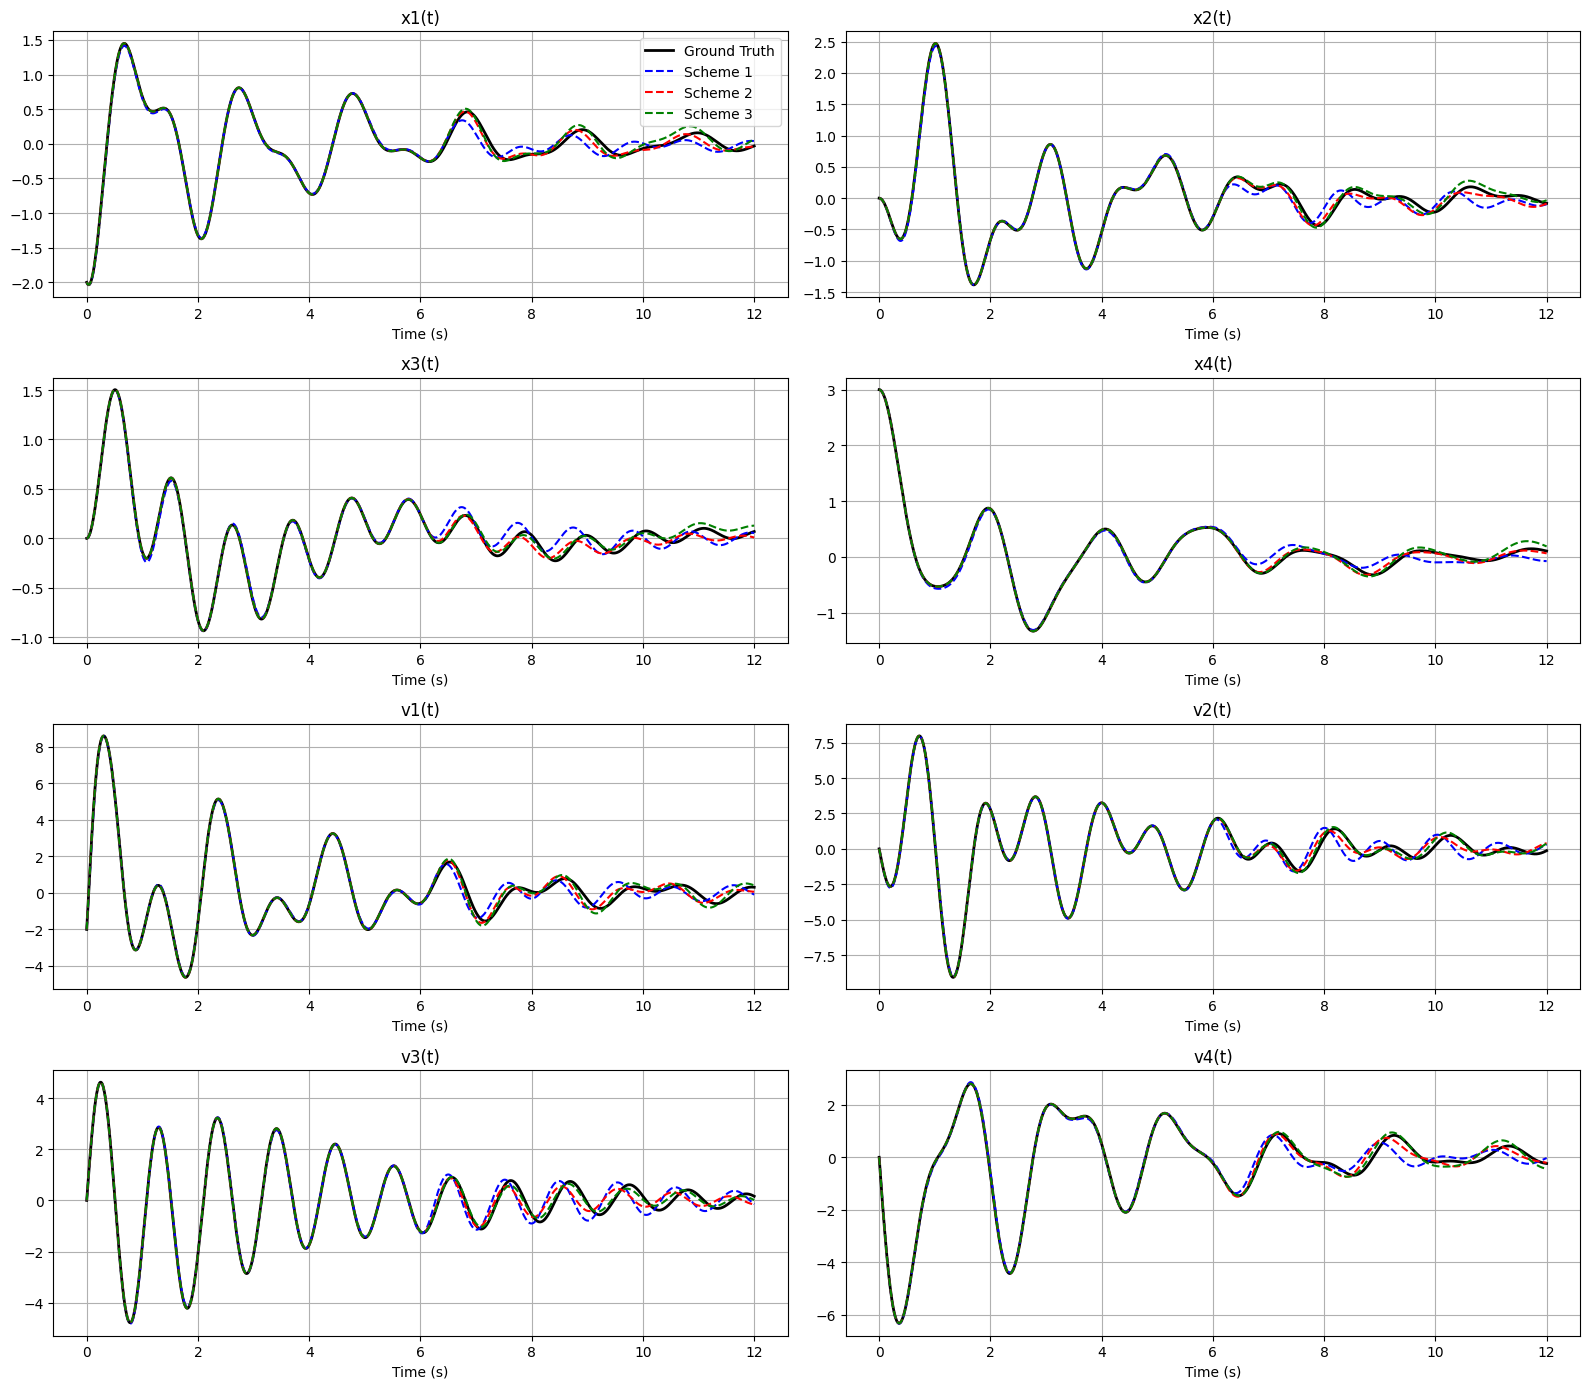

In [99]:
# --- Evaluate IC2 plot (0–12s) ---

with torch.no_grad():
    pred2_s1 = odeint(model1, h0_2, t_test, method='rk4')  # scheme 1
    pred2_s2 = odeint(model2, h0_2, t_test, method='rk4')  # scheme 2
    pred2_s3 = odeint(model3, h0_2, t_test, method='rk4')  # scheme 3

# Plot full 12 seconds
plot_ic_results(t_test, traj2_test, pred2_s1, pred2_s2, pred2_s3, save_path="ic2_full_12s.png")


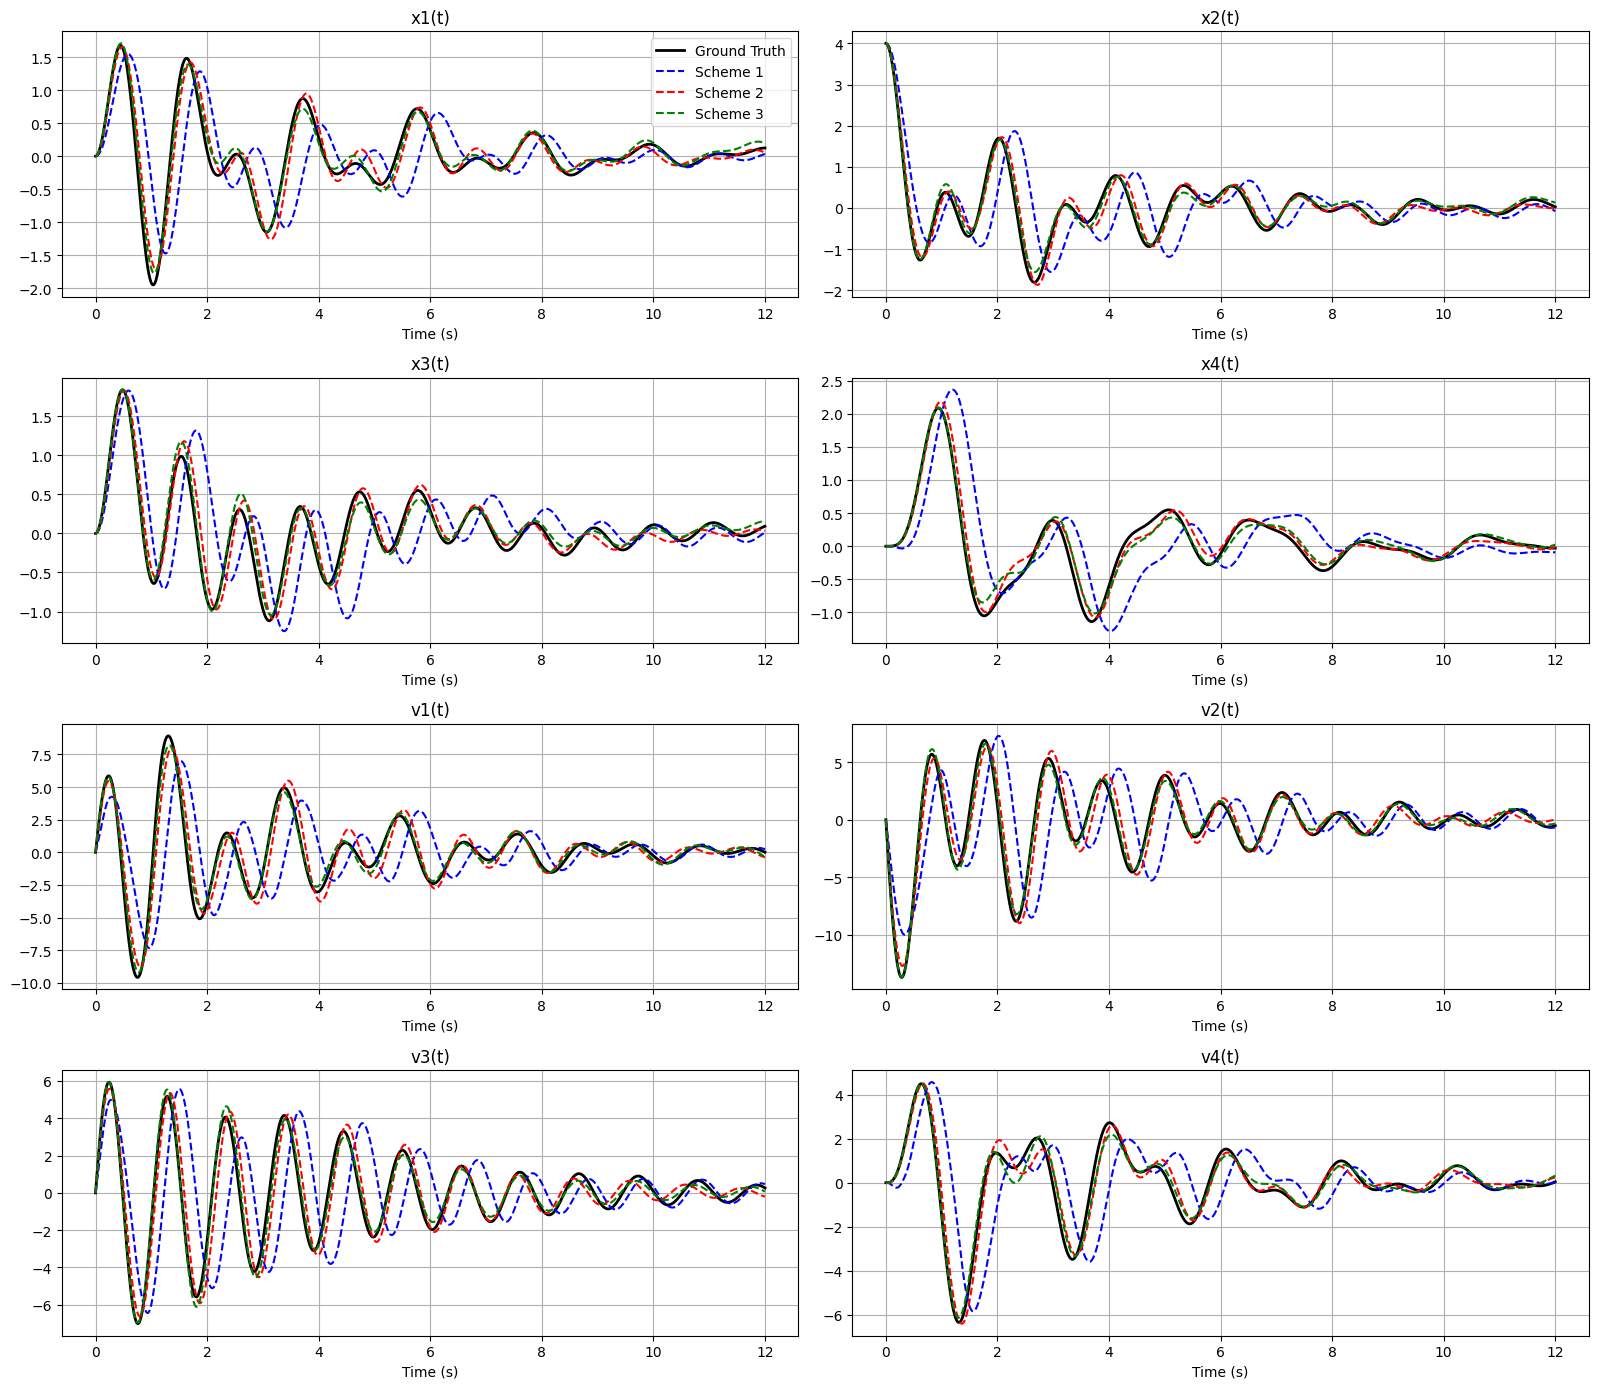

In [100]:
# --- Evaluate IC3 plot (0–12s) ---

with torch.no_grad():
    pred3_s1 = odeint(model1, h0_3, t_test, method='rk4')  # scheme 1
    pred3_s2 = odeint(model2, h0_3, t_test, method='rk4')  # scheme 2
    pred3_s3 = odeint(model3, h0_3, t_test, method='rk4')  # scheme 3

# Plot full 12 seconds
plot_ic_results(t_test, traj3_test, pred3_s1, pred3_s2, pred3_s3, save_path="ic3_full_12s.png")

In [101]:
def build_sindy_discrepancy(h_true_list, scheme, K_true, C_true, k_nl_true, device="cpu"):

    # Concatenate all true trajectories into a single long dataset
    # h_true has shape (N, 8), where N = total number of time steps from all trajs
    h_true = torch.cat(h_true_list, dim=0).to(device)  # (N,8)

    # Split into displacements (x) and velocities (v)
    x = h_true[:, :4]
    v = h_true[:, 4:]

    # Compute the analytic discrepancy a_disc(x,v) for this scheme
    # using the known physics (K_true, C_true, k_nl_true).
    a_disc = discrepancy_reference(x, v, scheme,K_true.to(device), C_true.to(device), k_nl_true)  # shape (N, 4)

    # SINDy expects numpy arrays, not torch tensors
    X = h_true.cpu().numpy()   # full state [x1..x4, v1..v4]
    Y = a_disc.cpu().numpy()   # target discrepancy accelerations [dv1..dv4]

    return X, Y


In [102]:
import pysindy as ps

def run_sindy_discrepancy(h_true_list, scheme, K_true, C_true, k_nl_true, dt, threshold=0.05, device="cpu"):


    # 1) Build data (X = states, Y = discrepancy accelerations)
    #    X: (N, 8)  -> [x1..x4, v1..v4]
    #    Y: (N, 4)  -> [dv1_disc, dv2_disc, dv3_disc, dv4_disc]
    X, Y = build_sindy_discrepancy(h_true_list, scheme, K_true, C_true, k_nl_true, device=device)

    # 2) Polynomial feature library up to degree 3:
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # 3) Sparse regression optimizer (STLSQ) with given threshold
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    print(f"\n===== SINDy discrepancy equations for Scheme {scheme} =====")

    # 4) Fit 4 separate SINDy models: one for each dv_i discrepancy
    for i in range(4):
        # Select i-th component of discrepancy as target (shape (N,1))
        y_i = Y[:, i:i+1]

        # New SINDy model for this DOF
        model = ps.SINDy(feature_library=poly_lib,optimizer=optimizer)

        # We pass X as input, y_i as x_dot, and give dt for time step
        model.fit(X, t=dt, x_dot=y_i)

        # Coefficients for this DOF's equation
        coeffs = model.coefficients()[0]   # 1 row because x_dot has 1 component
        feats  = model.get_feature_names() # names of basis functions (like x0, x0^2, x0^3, ...)

        print(f"\n--- dv{i+1}_disc ---")
        terms = []
        for c, term in zip(coeffs, feats):
            # Skip exact zeros (or near-zero) terms
            if abs(c) > 1e-9:
                terms.append(f"{c:+.4f} * {term}")
        if len(terms) == 0:
            # If everything is zero, print 0
            print("0")
        else:
            # Otherwise print: dv_i = sum_j c_j * phi_j(x)
            print("dv{} = ".format(i+1) + " ".join(terms))


In [103]:
dt = 0.01

sindy_disc_s2 = run_sindy_discrepancy(h_true_list=[traj2_train],scheme=2, K_true=K, C_true=C, k_nl_true=k_nl_true, dt=dt, threshold=0.05, device=device)
sindy_disc_s3 = run_sindy_discrepancy(h_true_list=[traj2_train],scheme=3, K_true=K, C_true=C, k_nl_true=k_nl_true, dt=dt, threshold=0.05, device=device)



===== SINDy discrepancy equations for Scheme 2 =====

--- dv1_disc ---
dv1 = -6.0000 * x0 +3.0000 * x1 -0.1500 * x4 -2.0000 * x0^3

--- dv2_disc ---
dv2 = +3.0000 * x0 -6.0000 * x1 +3.0000 * x2 -0.1500 * x5

--- dv3_disc ---
dv3 = +3.0000 * x1 -6.0000 * x2 +3.0000 * x3 -0.1500 * x6

--- dv4_disc ---
dv4 = +3.0000 * x2 -3.0000 * x3 -0.1500 * x7

===== SINDy discrepancy equations for Scheme 3 =====

--- dv1_disc ---
dv1 = -2.0000 * x0^3

--- dv2_disc ---
0

--- dv3_disc ---
0

--- dv4_disc ---
0


In [104]:
def build_sindy_discrepancy_from_nn(h_true_list, model, device="cpu"):

    # Combine all TRUE trajectories (from training or test)
    # into a single dataset that SINDy will analyze
    h_true = torch.cat(h_true_list, dim=0).to(device)  # shape (N,8)

    # Evaluate the neural network on the TRUE states
    with torch.no_grad():
        a_disc_nn = model.mlp(h_true)  # shape (N,4)

    # Convert to numpy for PySINDy
    X = h_true.cpu().numpy()     # full state
    Y = a_disc_nn.cpu().numpy()  # NN discrepancy

    return X, Y


In [105]:
import pysindy as ps

def run_sindy_discrepancy_from_nn(h_true_list, model, dt, threshold=0.05, device="cpu"):


    # Build (X, Y) dataset from NN outputs
    X, Y = build_sindy_discrepancy_from_nn(h_true_list=h_true_list,model=model,device=device)
    # X: (N,8) state vectors
    # Y: (N,4) NN-generated discrepancy accelerations

    # Polynomial basis for SINDy (up to x^3, no cross terms)
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # Sparse optimizer for selecting few active terms
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    print("\n===== SINDy discrepancy equations from NN (learned) =====")

    models = []  # to store one SINDy model per dv component

    # Fit four separate equations: dv1, dv2, dv3, dv4
    for i in range(4):
        y_i = Y[:, i:i+1]  # extract column i

        model_sindy = ps.SINDy(feature_library=poly_lib,optimizer=optimizer)

        # Fit SINDy with known dt and known derivative y_i
        model_sindy.fit(X, t=dt, x_dot=y_i)

        models.append(model_sindy)

        # Retrieve coefficients and feature names
        coeffs = model_sindy.coefficients()[0]
        feats  = model_sindy.get_feature_names()

        print(f"\n--- dv{i+1}_disc (NN) ---")
        terms = []
        for c, term in zip(coeffs, feats):
            # Print only nonzero terms → sparse result
            if abs(c) > 1e-9:
                terms.append(f"{c:+.4f} * {term}")

        # If nothing survived thresholding → output zero
        if len(terms) == 0:
            print("0")
        else:
            print("dv{} = ".format(i+1) + " ".join(terms))

    # Return all four DOF models for downstream coefficient comparison
    return models


In [106]:
models_s2_nn = run_sindy_discrepancy_from_nn(h_true_list=[traj2_train],model=model2,dt=dt,threshold=0.05,device=device)
models_s3_nn = run_sindy_discrepancy_from_nn(h_true_list=[traj2_train],model=model3,dt=dt,threshold=0.01,device=device)



===== SINDy discrepancy equations from NN (learned) =====

--- dv1_disc (NN) ---
dv1 = -6.0136 * x0 +3.0028 * x1 -0.1499 * x4 -1.9914 * x0^3

--- dv2_disc (NN) ---
dv2 = +2.9984 * x0 -5.9992 * x1 +3.0019 * x2 -0.1500 * x5

--- dv3_disc (NN) ---
dv3 = +2.9999 * x1 -5.9991 * x2 +2.9994 * x3 -0.1500 * x6

--- dv4_disc (NN) ---
dv4 = +2.9988 * x2 -2.9996 * x3 -0.1501 * x7

===== SINDy discrepancy equations from NN (learned) =====

--- dv1_disc (NN) ---
dv1 = -2.0000 * x0^3

--- dv2_disc (NN) ---
0

--- dv3_disc (NN) ---
0

--- dv4_disc (NN) ---
0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
